# 데이터

In [1]:
# 라이브러리 불러오기
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

import re
from collections import Counter
import sentencepiece as spm
from konlpy.tag import Okt
from konlpy.tag import Mecab
import csv 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
from itertools import combinations
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix
)

from keras.utils.vis_utils import plot_model

In [2]:
# 한글 폰트에 문제가 생겼을 때

# 한글 폰트 설치
!apt-get update -qq
!apt-get install -qq fonts-nanum

# 설치한 폰트를 matplotlib에서 사용할 수 있도록 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 나눔 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')  # 폰트 설정

## 데이터 업로드

#### 학습 데이터 불러오기

프롬프트로 생성된 '일반 대화' 합성 데이터와 원본 데이터가 합쳐진 파일

In [3]:
train_data_path ="/aiffel/aiffel/dlthon-minions/share/data/conversations.csv"
train_data = pd.read_csv(train_data_path)
# 원본 데이터 저장
origin_data = train_data

In [4]:
train_data.sample(10)

,idx,class,conversation
3238,3238,일반 대화,"학원 다녀?\n응, 영어 학원 다녀.\n동아리 활동 어때?\n정말 즐거워, 새로운 ..."
1818,1818,기타 괴롭힘 대화,이새끼 이것도 틀려?\n틀린건가?\n바보자식. 이래가지고 대학은 가겠니\n공부열심히...
360,360,기타 괴롭힘 대화,자꾸 이렇게 집착해서 전화자꾸하지마 \n한번만 만날수 없니 딱 한번만\n우린 헤어졌...
3757,3757,협박 대화,넌 그냥 죽어야해 이 한국남자야\n그러지 마세요 왜 그러세요\n넌 그냥 죽어 \n죽...
4761,4761,직장 내 괴롭힘 대화,강인턴 혹시 대학은 뭐 어디 나왔나? 아 이런거 물어보는 거 실례려나\n아유 실례는...
1209,1209,직장 내 괴롭힘 대화,부장님.\n어? 김대리 무슨일이야?\n저번에 말씀드린 휴가 말인데요.\n휴가? 아아...
2823,2823,기타 괴롭힘 대화,띠로리띠띠로리리\n 바보래요 바보래요\n 쟨 그말도 못알아들을걸?\n 나나. 아알아...
1225,1225,협박 대화,민우야 엄마 사랑하니?\n네 엄마. 사랑하죠.\n그럼 혹시 민우가 엄마 좀 도와줄 ...
721,721,갈취 대화,우리 범생이 돈 얼마 있어?\n없어\n그럼 돈 나오면 10원에 한대씩?야 뒤져\n하...
1762,1762,갈취 대화,어이 형씨 오랜만이네?\n 왜이러세요. 금방 갚겠다고 했잖아요.\n 이자가 그새 불...


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4950 entries, 0 to 4949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           4950 non-null   int64 
 1   class         4950 non-null   object
 2   conversation  4950 non-null   object
dtypes: int64(1), object(2)
memory usage: 116.1+ KB


## 전처리

### 기본 전처리

#### 중복값 여부 찾아보기

In [6]:
# 중복값 찾기
duplicates = train_data[train_data.duplicated()]
duplicates

,idx,class,conversation


중복값 없음

#### 결측치 여부 확인하기

In [7]:
# 결측치 여부 확인하기
train_data.isnull().sum()

idx             0
class           0
conversation    0
dtype: int64

결측치 없음

#### 클래스 컬럼 인코딩하기

In [8]:
# 'class'를 'type'으로 매핑하는 딕셔너리 생성하기
class_to_type = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

In [9]:
# 'class' 열을 기반으로 새로운 'type' 열 추가하기
train_data['type'] = train_data['class'].map(class_to_type)

In [10]:
# type 열 추가했는지 확인하기
train_data.head()

,idx,class,conversation,type
0,0,일반 대화,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,1,기타 괴롭힘 대화,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,2,협박 대화,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,3,직장 내 괴롭힘 대화,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,4,일반 대화,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4


In [11]:
# 기존 idx, class 컬럼 삭제하기
new_train_data = train_data.drop(['idx', 'class'], axis=1)
# idx, class 컬럼 삭제했는지 확인하기
new_train_data.head()

,conversation,type
0,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4


In [12]:
# new_train_data를 train_data에 덮어 씌우기
train_data = new_train_data

### 텍스트 전처리

#### 한글 외 문자 삭제
한글, '?', '!', '.', '.', 공백 유지

In [13]:
# 전처리 함수
def preprocess_sentence(sentence): 
    # \n을 공백으로 바꾸기
    sentence = re.sub("\n", " ", sentence)
    
    # (ㄱ-ㅎ, ㅏ-ㅣ, ".", "?", "!", ",", ' ')를 제외한 모든 문자를 없애기
    sentence = re.sub("[^ㄱ-ㅣ가-힣.?!, ]", "", sentence)
    
    # 단어와 구두점(punctuation) 사이에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    return sentence

In [14]:
# 전처리 데이터 새로운 column에 저장
train_data['preprocessed'] = train_data['conversation'].apply(preprocess_sentence)
train_data['preprocessed']

0       학교 점심 뭐 나와 ?  주로 한식이 나와 .  학원 다녀 ?  응 ,  영어 학원...
1       어이 거기 뒤뚱거리는 놈  나 ?  그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐 ...
2       너 그따위로 운전하면 확 갈아마셔버린다 .   뭐라구 ?   나와 이 자식아 .  ...
3       길동씨 이번에 이것좀 처리해요 이거 제가 한게 아닌데요 팀에서 내가 니가가 어딨어 ...
4       비가 많이 오네 .  우산 가져왔어 ?  날씨가 추워졌어 .  맞아 ,  이제 겨울...
                              ...                        
4945    오 깡패다 니 지금 뭐라했노 말하는것도 깡패네 닌 죽었다 시키야 어디서 건방지게 아...
4946    이거 니 주민등록증 아니야 ?  잃어버린줄 알았는데 . 고마워 !  고맙긴 뭘 근데...
4947    여행 준비 다 했어 ?  아직 ,  짐 싸는 중이야 .  여행 가방은 다 쌌어 ? ...
4948    그거 사줘 안사주면 죽어버릴거야  이러지마 돈없어 나한테 해준게 뭐있어 !  !  ...
4949    얘들아 .  이 년 몰골좀 봐 .   야 .  너 좀 씻고다녀 .  우웩 너희가 나...
Name: preprocessed, Length: 4950, dtype: object

In [15]:
# 기존 'conversation' column 전처리한 데이터로 바꾸기
train_data['conversation'] = train_data['preprocessed']
train_data.drop('preprocessed', axis=1)

,conversation,type
0,"학교 점심 뭐 나와 ? 주로 한식이 나와 . 학원 다녀 ? 응 , 영어 학원...",4
1,어이 거기 뒤뚱거리는 놈 나 ? 그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐 ...,3
2,너 그따위로 운전하면 확 갈아마셔버린다 . 뭐라구 ? 나와 이 자식아 . ...,0
3,길동씨 이번에 이것좀 처리해요 이거 제가 한게 아닌데요 팀에서 내가 니가가 어딨어 ...,2
4,"비가 많이 오네 . 우산 가져왔어 ? 날씨가 추워졌어 . 맞아 , 이제 겨울...",4
...,...,...
4945,오 깡패다 니 지금 뭐라했노 말하는것도 깡패네 닌 죽었다 시키야 어디서 건방지게 아...,0
4946,이거 니 주민등록증 아니야 ? 잃어버린줄 알았는데 . 고마워 ! 고맙긴 뭘 근데...,1
4947,"여행 준비 다 했어 ? 아직 , 짐 싸는 중이야 . 여행 가방은 다 쌌어 ? ...",4
4948,그거 사줘 안사주면 죽어버릴거야 이러지마 돈없어 나한테 해준게 뭐있어 ! ! ...,0


#### 불용어 삭제
[불용어 리스트 출처](https://www.ranks.nl/stopwords/korean)

In [16]:
# 불용어 리스트 불러오기
stopwords_path = "/aiffel/aiffel/dlthon-minions/share/preprocess/ko_stopwords.txt"
with open(stopwords_path, 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()

#### 토큰화

```!pip install konlpy```

In [17]:
# 단어사전 크기 20000으로 제한
VOCAB_SIZE=20000

Okt 토크나이저 활용

In [18]:
# Okt로 토큰화
tokenizer=Okt()

def tokenize(conversation, tokenizer):
    return [token for token in tokenizer.morphs(conversation) if token not in stopwords]

# 각 conversation을 토큰화하여 새로운 열 'tokenized'에 저장
train_data['tokenized'] = train_data['conversation'].apply(lambda x: tokenize(x, tokenizer))
tokenized_df = train_data[['type', 'tokenized']]

## Augmentation
rd, rs 방법  
[코드 참조](https://github.com/catSirup/KorEDA/blob/master/eda.py)

In [19]:
import random

########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################
def random_deletion(words, p):
	if len(words) == 1:
		return words

	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################
def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)

	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0

	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words

	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
	return new_words

In [20]:
words = ['가', '나', '다', '라', '마', '바', '사']
a= random_deletion(words, 0.2)
b = random_swap(words, 3)
print(a)
print(b)

['가', '나', '마', '바']
['나', '가', '라', '사', '마', '바', '다']


In [21]:
def augmentation(df):
    new_rows = []
    for _, row in df.iterrows():
        type_int = row['type']
        # '일반 대화' 이외의 클래스에만 적용
        # 2배씩 늘어남
        if type_int != 4:
            words = row['tokenized']
            # 랜덤으로 augmentation 방식 적용
            use_rd = random.choice([True, False])
            # random deletion
            # p의 확률로 제거
            if use_rd:
                p = random.uniform(0, 1)
                new_words = random_deletion(words, p)
            # random swap
            # n회만큼 swap
            else:
                n = random.randint(1, len(words)//2)
                new_words = random_swap(words, n)
            new_rows.append([type_int, new_words])
    
    # 기존 데이터에 새로운 데이터 추가
    augmented_df = df.append(pd.DataFrame(new_rows, columns=df.columns), ignore_index=True)
    return augmented_df

In [22]:
augmented_data = augmentation(tokenized_df)

In [23]:
augmented_data

,type,tokenized
0,4,"[학교, 점심, 뭐, 나와, ?, 주로, 한식, 나와, ., 학원, 다녀, ?, ,..."
1,3,"[뒤뚱거리, 는, 놈, ?, 뒤뚱거리, 는, 놈, 밖에, 더, 있냐, ?, 놀리지마..."
2,0,"[그따위, 운전, 하면, 확, 갈아, 마셔, 버린다, ., 뭐라구, ?, 나와, 자..."
3,2,"[길동, 씨, 것좀, 처리, 거, 한, 게, 아닌데요, 팀, 내, 니, 가가, 어딨..."
4,4,"[비, 많이, 오네, ., 우산, 가져왔어, ?, 날씨, 추워졌어, ., 맞아, ,..."
...,...,...
8895,1,"[자네, 옆집, 할망구, 랑, 만나는가, ?, 알았는가, ?, 어제, 되겠는가, ?..."
8896,0,"[깡패, 다, 니, 지금, 뭐라, 했노, 말, 깡패, 닌, 죽었다, 시키야, 어디서..."
8897,1,"[만원, 니, ., 등록증, 아니야, ?, 잃어버린줄, 알았는데, 원래, 하고, !..."
8898,0,"[사줘, 뭐]"


In [24]:
# 중복값 확인
# Convert the 'tokenized' column to strings for duplication checking
augmented_data['tokenized_str'] = augmented_data['tokenized'].apply(lambda x: ' '.join(x))

# Check for duplicates based on the string representation of the 'tokenized' column
duplicates = augmented_data[augmented_data.duplicated(subset=['tokenized_str'])]
print('중복된 행 개수: ', len(duplicates))

unique_augmented_data = augmented_data.drop_duplicates(subset=['tokenized_str'])
unique_augmented_data = unique_augmented_data.drop(columns=['tokenized_str'])
unique_augmented_data


중복된 행 개수:  160


,type,tokenized
0,4,"[학교, 점심, 뭐, 나와, ?, 주로, 한식, 나와, ., 학원, 다녀, ?, ,..."
1,3,"[뒤뚱거리, 는, 놈, ?, 뒤뚱거리, 는, 놈, 밖에, 더, 있냐, ?, 놀리지마..."
2,0,"[그따위, 운전, 하면, 확, 갈아, 마셔, 버린다, ., 뭐라구, ?, 나와, 자..."
3,2,"[길동, 씨, 것좀, 처리, 거, 한, 게, 아닌데요, 팀, 내, 니, 가가, 어딨..."
4,4,"[비, 많이, 오네, ., 우산, 가져왔어, ?, 날씨, 추워졌어, ., 맞아, ,..."
...,...,...
8895,1,"[자네, 옆집, 할망구, 랑, 만나는가, ?, 알았는가, ?, 어제, 되겠는가, ?..."
8896,0,"[깡패, 다, 니, 지금, 뭐라, 했노, 말, 깡패, 닌, 죽었다, 시키야, 어디서..."
8897,1,"[만원, 니, ., 등록증, 아니야, ?, 잃어버린줄, 알았는데, 원래, 하고, !..."
8898,0,"[사줘, 뭐]"


In [25]:
# 클래스 별 샘플 개수 확인
Counter(unique_augmented_data['type'])

Counter({4: 1000, 3: 2088, 0: 1775, 2: 1934, 1: 1943})

In [26]:
tokenized_df = unique_augmented_data

#### 단어사전 생성

In [27]:
def create_word_to_index(vocab_path):
    # 인코딩에 활용할 단어사전 딕셔너리 생성
    word_to_index = {}
    with open(vocab_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            tmp = line.split(": ")
            word = tmp[0]
            idx = int(tmp[1])
            word_to_index.update({word: idx})
    return word_to_index

In [28]:
vocab_path = '/aiffel/aiffel/dlthon-minions/share/preprocess/vocab.txt'
word_to_index=create_word_to_index(vocab_path)
word_to_index

{'<pad>': 0,
 '<unk>': 1,
 '.': 2,
 '?': 3,
 ',': 4,
 '!': 5,
 '내': 6,
 '해': 7,
 '뭐': 8,
 '는': 9,
 '도': 10,
 '좋아해': 11,
 '거': 12,
 '말': 13,
 '다': 14,
 '은': 15,
 '돈': 16,
 '친구': 17,
 '잘': 18,
 '니': 19,
 '있어': 20,
 '랑': 21,
 '요': 22,
 '영화': 23,
 '만': 24,
 '진짜': 25,
 '이야': 26,
 '정말': 27,
 '죄송합니다': 28,
 '한': 29,
 '게': 30,
 '지금': 31,
 '할': 32,
 '고': 33,
 '하고': 34,
 '한테': 35,
 '오늘': 36,
 '주로': 37,
 '님': 38,
 '주말': 39,
 '그냥': 40,
 '여행': 41,
 '돼': 42,
 '집': 43,
 '많이': 44,
 '자주': 45,
 '제발': 46,
 '가족': 47,
 '알': 48,
 '생각': 49,
 '거야': 50,
 '적': 51,
 '이랑': 52,
 '하는': 53,
 '더': 54,
 '운동': 55,
 '지': 56,
 '그렇게': 57,
 '너무': 58,
 '했어': 59,
 '빨리': 60,
 '회사': 61,
 '새끼': 62,
 '씨': 63,
 '만나': 64,
 '하면': 65,
 '아니야': 66,
 '없어': 67,
 '걸': 68,
 '수': 69,
 '애': 70,
 '면': 71,
 '줄': 72,
 '그런': 73,
 '이렇게': 74,
 '그게': 75,
 '그건': 76,
 '어제': 77,
 '서': 78,
 '이제': 79,
 '넌': 80,
 '대리': 81,
 '인데': 82,
 '사진': 83,
 '나도': 84,
 '엄마': 85,
 '아침': 86,
 '다녀': 87,
 '취미': 88,
 '부모님': 89,
 '만원': 90,
 '싶어': 91,
 '본': 92,
 '뭘': 93,
 '

#### 정수인코딩

In [29]:
# 'tokenized' 열의 데이터를 정수 인코딩
def encode_tokens(tokens, word_to_index):
    unk_index = word_to_index['<unk>']
    return [word_to_index.get(token, unk_index) for token in tokens]

tokenized_df['encoded'] = tokenized_df['tokenized'].apply(lambda x: encode_tokens(x, word_to_index))

In [30]:
tokenized_df.head()

,type,tokenized,encoded
0,4,"[학교, 점심, 뭐, 나와, ?, 주로, 한식, 나와, ., 학원, 다녀, ?, ,...","[101, 171, 8, 166, 3, 37, 223, 166, 2, 155, 87..."
1,3,"[뒤뚱거리, 는, 놈, ?, 뒤뚱거리, 는, 놈, 밖에, 더, 있냐, ?, 놀리지마...","[6378, 9, 201, 3, 6378, 9, 201, 179, 54, 516, ..."
2,0,"[그따위, 운전, 하면, 확, 갈아, 마셔, 버린다, ., 뭐라구, ?, 나와, 자...","[1330, 883, 65, 584, 3547, 272, 707, 2, 5233, ..."
3,2,"[길동, 씨, 것좀, 처리, 거, 한, 게, 아닌데요, 팀, 내, 니, 가가, 어딨...","[356, 63, 1301, 338, 12, 29, 30, 1302, 203, 6,..."
4,4,"[비, 많이, 오네, ., 우산, 가져왔어, ?, 날씨, 추워졌어, ., 맞아, ,...","[162, 44, 611, 2, 612, 517, 3, 124, 631, 2, 15..."


## 전처리 후 분석

#### 패딩 적용

In [31]:
# 대화 최대 길이 150으로 설정
MAX_LENGTH = 150

In [32]:
X = pad_sequences(tokenized_df['encoded'], maxlen=MAX_LENGTH, padding='post', truncating='post')

## 데이터 분할

In [33]:
y = tokenized_df['type']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, shuffle=True, random_state=42)

print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :', len(y_train))
print('검증 데이터의 개수 :', len(X_val))
print('검증 레이블의 개수 :', len(y_val))
print('테스트 데이터의 개수 :', len(X_test))
print('테스트 레이블의 개수 :', len(y_test))

훈련 데이터의 개수 : 6992
훈련 레이블의 개수 : 6992
검증 데이터의 개수 : 874
검증 레이블의 개수 : 874
테스트 데이터의 개수 : 874
테스트 레이블의 개수 : 874


In [34]:
# 테스트 데이터셋 클래스 불균형 확인
counter = Counter(y_train)
counter.most_common()

[(3, 1681), (1, 1573), (2, 1551), (0, 1392), (4, 795)]

# 모델링

In [35]:
!pip install wandb==0.16.0

In [36]:
import wandb

key='809618c39f10bc0019fd6fd710cb28c698c30197'
wandb.login(key = key)

wandb: Currently logged in as: 4rldur0 (4-rldur0). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [37]:
sweep_config = {
    "name": "sweep_test_nlp",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.01,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            },
        "batch_size": {
            "values": [16, 32, 64]
            },
        "optimizer": {
            "values": ["adam", "rmsprop"]
            },
        "dropout_rate":{
            "values": [0.2, 0.3, 0.4, 0.5]
            }
        }
    }

default_config = {
        "vocab" : VOCAB_SIZE,
        "max_len" : MAX_LENGTH, 
        "embeddings" : 128,
        "units_64" : 64,
        "units_128" : 128,
        "units_256" : 256,
        "units_512" : 512,
        "units_1024" : 1024,
        "units_2048" : 2048,
        "kernel_3" : 3,
        "kernel_5" : 5,
        "class_num" : 5,
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
    }

In [38]:
def build_model_baseline(config):
    model=keras.models.Sequential()
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    model.add(keras.layers.GRU(units = config.units_256, return_sequences = True))
    model.add(keras.layers.GRU(units = config.units_512))
    model.add(keras.layers.Dense(config.units_1024, activation='relu'))
    model.add(keras.layers.Dense(config.class_num, activation='softmax'))  
    return model

In [39]:
def build_model_1DCNN(config):
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    model.add(keras.layers.Conv1D(config.embeddings, config.kernel_5, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=4))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(config.units_128, activation='relu'))
    model.add(keras.layers.Dense(config.class_num, activation='softmax')) 
    return model

In [52]:
X_train.shape

(6992, 150)

In [72]:
def build_model_1DCNN_large(config):
    model = keras.models.Sequential(name="large_1DCNN")
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    # 첫 번째 합성곱 층
    model.add(keras.layers.Conv1D(filters=config.units_64, kernel_size=config.kernel_3, activation='relu'))
    model.add(keras.layers.Conv1D(filters=config.units_64, kernel_size=config.kernel_3, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    
    # 두 번째 합성곱 층
    model.add(keras.layers.Conv1D(filters=config.units_128, kernel_size=config.kernel_3, activation='relu'))
    model.add(keras.layers.Conv1D(filters=config.units_128, kernel_size=config.kernel_3, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    
    # 세 번째 합성곱 층
    model.add(keras.layers.Conv1D(filters=config.units_256, kernel_size=config.kernel_3, activation='relu'))
    model.add(keras.layers.Conv1D(filters=config.units_256, kernel_size=config.kernel_3, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    
    # 전역 평균 풀링층
    model.add(keras.layers.GlobalAveragePooling1D())
    
    # 완전 연결층
    model.add(keras.layers.Dense(config.units_256, activation='relu'))
    model.add(keras.layers.Dropout(config.dropout_rate))
    model.add(keras.layers.Dense(config.units_128, activation='relu'))
    model.add(keras.layers.Dropout(config.dropout_rate))
    
    # 출력층
    model.add(keras.layers.Dense(config.class_num, activation='softmax')) 
    return model

In [41]:
def build_model_1DCNN_GRU(config):
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    model.add(keras.layers.SpatialDropout1D(config.dropout_rate))
    model.add(keras.layers.Conv1D(config.embeddings, config.kernel_5, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=4))
    model.add(keras.layers.GRU(config.units_128, dropout=config.dropout_rate, recurrent_dropout=config.dropout_rate))
    model.add(keras.layers.Dense(config.class_num, activation='softmax'))
    return model

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import wandb

# heatmap으로 비교 결과를 그려주는 함수
def plot_table(cm):
    title = "Overall Prediction Result"
    # 실제 클래스명으로 변환
    classes = [
        '협박 대화',
        '갈취 대화',
        '직장 내 괴롭힘 대화',
        '기타 괴롭힘 대화',
        '일반 대화'
    ]
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, annot_kws={'size': 30})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    return plt

# epoch이 모두 끝나면 각 클래스별 GT와 예측값을 비교한 표 시각화
# 5x5의 표의 [i,j]의 위치는 실제값은 i번째 클래스이고, 예측값은 j번째 클래스임을 나타냄
class CompareResultsCallback(keras.callbacks.Callback):
    def __init__(self, X_test, y_test, class_num):
        super().__init__()
        self.X_test = X_test
        self.y_test = y_test
        self.class_num = class_num
        # 전체 표 초기화
        self.table = np.zeros((self.class_num, self.class_num), dtype=np.int32)

    def on_train_end(self, epoch, logs=None):
        # 마지막 epoch에서만 계산
        pred_test = self.model.predict(self.X_test).argmax(axis=1)
        self.y_test = np.array(self.y_test)
        pred_test = np.array(pred_test)
            
        # 5개의 클래스에서 두 개씩 뽑아내어 비교
        # 실제값이 class_a일 때, 예측값을 claas_b로 예측한 횟수
        for class_a in range(self.class_num):
            for class_b in range(self.class_num):
                num = len(np.where((self.y_test == class_a) & (pred_test == class_b))[0])
                self.table[class_a, class_b] += num

        # 표 그리기
        cr_plot = plot_table(self.table)
            
        # wandb에 로그로 저장
        cr_image = wandb.Image(cr_plot)
        wandb.log({"Overall Prediction Result": cr_image})


In [74]:
# 학습 함수 정의
# CompareResultsCallback 테스트 데이터셋을 활용하므로 인자로 넣어줌
def train(default_config, X_train, X_val, X_test, y_test):

    wandb.init(config = default_config)
    config = wandb.config
    
    keras.backend.clear_session()

    # Model
    model = build_model_1DCNN_large(config)

    # Compile
    model.compile(optimizer = config.optimizer,
                  loss = config.loss,
                  metrics = config.metrics)
    
    # 비교 결과 그리는 콜백
    cr_callback = CompareResultsCallback(X_test, y_test, config.class_num)
    # earlystopping 콜백
    es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
        
    history = model.fit(X_train, y_train,
              epochs = config.epoch,
              batch_size = config.batch_size,
              validation_data = (X_val, y_val),
              callbacks=[wandb.keras.WandbCallback(), cr_callback, es_callback])
    
    # test dataset으로 accuracy 계산    
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
    pred_test = model.predict(X_test).argmax(axis=1)
    # test dataset으로 f1 score 계산
    f1_score_res = f1_score(y_test, pred_test, average='micro')

    # wandb에 log 추가
    wandb.log({
        "Test Accuracy Rate": test_accuracy,
        "Test F1 Score": f1_score_res,
        "Test Error Rate": 1 - test_accuracy
    })
    
    return history

Create sweep with ID: n30n80ai
Sweep URL: https://wandb.ai/aiffel_minions/DLthon_CNN_large_Augmented/sweeps/n30n80ai


wandb: Agent Starting Run: mavjbrgy with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epoch: 7
wandb: 	learning_rate: 0.03139737699809586
wandb: 	optimizer: adam


Epoch 1/7
437/437 [==============================] - 4s 8ms/step - loss: 1.1949 - accuracy: 0.4103 - val_loss: 0.9368 - val_accuracy: 0.6327
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024129-mavjbrgy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024129-mavjbrgy/files/model-best)... Done. 0.1s


Epoch 2/7
437/437 [==============================] - 3s 7ms/step - loss: 0.6895 - accuracy: 0.7210 - val_loss: 0.5475 - val_accuracy: 0.8043
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024129-mavjbrgy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024129-mavjbrgy/files/model-best)... Done. 0.1s


Epoch 3/7
437/437 [==============================] - 3s 7ms/step - loss: 0.3484 - accuracy: 0.8807 - val_loss: 0.3939 - val_accuracy: 0.8730
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024129-mavjbrgy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024129-mavjbrgy/files/model-best)... Done. 0.1s


Epoch 4/7
437/437 [==============================] - 3s 7ms/step - loss: 0.1948 - accuracy: 0.9379 - val_loss: 0.3504 - val_accuracy: 0.8924
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024129-mavjbrgy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024129-mavjbrgy/files/model-best)... Done. 0.1s


Epoch 5/7
437/437 [==============================] - 3s 7ms/step - loss: 0.1263 - accuracy: 0.9565 - val_loss: 0.3171 - val_accuracy: 0.8993
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024129-mavjbrgy/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024129-mavjbrgy/files/model-best)... Done. 0.1s


Epoch 6/7
437/437 [==============================] - 3s 7ms/step - loss: 0.0939 - accuracy: 0.9670 - val_loss: 0.4095 - val_accuracy: 0.9222
Epoch 7/7
437/437 [==============================] - 3s 7ms/step - loss: 0.0950 - accuracy: 0.9724 - val_loss: 0.3963 - val_accuracy: 0.9222
28/28 - 0s - loss: 0.5314 - accuracy: 0.8833


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▅▇████
epoch,▁▂▃▅▆▇█
loss,█▅▃▂▁▁▁
val_accuracy,▁▅▇▇▇██
val_loss,█▄▂▁▁▂▂
Test Accuracy Rate,0.8833
Test Error Rate,0.1167
Test F1 Score,0.8833


wandb: Agent Starting Run: st613cv6 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epoch: 7
wandb: 	learning_rate: 0.046420729056869225
wandb: 	optimizer: adam


Epoch 1/7
110/110 [==============================] - 2s 12ms/step - loss: 1.3715 - accuracy: 0.3328 - val_loss: 1.0671 - val_accuracy: 0.4748
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024220-st613cv6/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024220-st613cv6/files/model-best)... Done. 0.1s


Epoch 2/7
110/110 [==============================] - 1s 10ms/step - loss: 0.9353 - accuracy: 0.5605 - val_loss: 0.7663 - val_accuracy: 0.6236
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024220-st613cv6/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024220-st613cv6/files/model-best)... Done. 0.1s


Epoch 3/7
110/110 [==============================] - 1s 10ms/step - loss: 0.6299 - accuracy: 0.7165 - val_loss: 0.6017 - val_accuracy: 0.7391
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024220-st613cv6/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024220-st613cv6/files/model-best)... Done. 0.1s


Epoch 4/7
110/110 [==============================] - 1s 10ms/step - loss: 0.4458 - accuracy: 0.8038 - val_loss: 0.5728 - val_accuracy: 0.7826
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024220-st613cv6/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024220-st613cv6/files/model-best)... Done. 0.1s


Epoch 5/7
110/110 [==============================] - 1s 10ms/step - loss: 0.3239 - accuracy: 0.8836 - val_loss: 0.5297 - val_accuracy: 0.8375
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024220-st613cv6/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024220-st613cv6/files/model-best)... Done. 0.1s


Epoch 6/7
110/110 [==============================] - ETA: 0s - loss: 0.2403 - accuracy: 0.91 - 1s 10ms/step - loss: 0.2415 - accuracy: 0.9168 - val_loss: 0.5603 - val_accuracy: 0.8547
Epoch 7/7
110/110 [==============================] - 1s 9ms/step - loss: 0.1528 - accuracy: 0.9487 - val_loss: 0.5291 - val_accuracy: 0.8741
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024220-st613cv6/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024220-st613cv6/files/model-best)... Done. 0.1s


28/28 - 0s - loss: 0.5827 - accuracy: 0.8432


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▄▅▆▇██
epoch,▁▂▃▅▆▇█
loss,█▅▄▃▂▂▁
val_accuracy,▁▄▆▆▇██
val_loss,█▄▂▂▁▁▁
Test Accuracy Rate,0.84325
Test Error Rate,0.15675
Test F1 Score,0.84325


wandb: Agent Starting Run: lsh1o5lv with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2
wandb: 	epoch: 8
wandb: 	learning_rate: 0.06009922515098843
wandb: 	optimizer: rmsprop


Epoch 1/8
110/110 [==============================] - 2s 11ms/step - loss: 1.2573 - accuracy: 0.3883 - val_loss: 0.9302 - val_accuracy: 0.5778
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024256-lsh1o5lv/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024256-lsh1o5lv/files/model-best)... Done. 0.1s


Epoch 2/8
110/110 [==============================] - 1s 10ms/step - loss: 0.8665 - accuracy: 0.6163 - val_loss: 1.3287 - val_accuracy: 0.5103
Epoch 3/8
110/110 [==============================] - 1s 9ms/step - loss: 0.6542 - accuracy: 0.7308 - val_loss: 0.6639 - val_accuracy: 0.7105
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024256-lsh1o5lv/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024256-lsh1o5lv/files/model-best)... Done. 0.1s


Epoch 4/8
110/110 [==============================] - 1s 10ms/step - loss: 0.4457 - accuracy: 0.8315 - val_loss: 0.4804 - val_accuracy: 0.8295
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024256-lsh1o5lv/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024256-lsh1o5lv/files/model-best)... Done. 0.1s


Epoch 5/8
110/110 [==============================] - 1s 10ms/step - loss: 0.3172 - accuracy: 0.8854 - val_loss: 0.5219 - val_accuracy: 0.8249
Epoch 6/8
110/110 [==============================] - 1s 9ms/step - loss: 0.2283 - accuracy: 0.9201 - val_loss: 0.5495 - val_accuracy: 0.8421
28/28 - 0s - loss: 0.5215 - accuracy: 0.8410


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▄▆▇██
epoch,▁▂▄▅▇█
loss,█▅▄▂▂▁
val_accuracy,▂▁▅███
val_loss,▅█▃▁▁▂
Test Accuracy Rate,0.84096
Test Error Rate,0.15904
Test F1 Score,0.84096


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: en3t36sz with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.4
wandb: 	epoch: 7
wandb: 	learning_rate: 0.01208669836268312
wandb: 	optimizer: rmsprop


Epoch 1/7
110/110 [==============================] - 2s 11ms/step - loss: 1.3112 - accuracy: 0.3517 - val_loss: 1.0372 - val_accuracy: 0.4622
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024337-en3t36sz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024337-en3t36sz/files/model-best)... Done. 0.1s


Epoch 2/7
110/110 [==============================] - 1s 10ms/step - loss: 1.0668 - accuracy: 0.4684 - val_loss: 0.9547 - val_accuracy: 0.5252
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024337-en3t36sz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024337-en3t36sz/files/model-best)... Done. 0.1s


Epoch 3/7
110/110 [==============================] - 1s 10ms/step - loss: 0.8699 - accuracy: 0.5947 - val_loss: 0.7064 - val_accuracy: 0.6808
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024337-en3t36sz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024337-en3t36sz/files/model-best)... Done. 0.1s


Epoch 4/7
110/110 [==============================] - 1s 10ms/step - loss: 0.6374 - accuracy: 0.7398 - val_loss: 0.8898 - val_accuracy: 0.6522
Epoch 5/7
110/110 [==============================] - 1s 9ms/step - loss: 0.4629 - accuracy: 0.8281 - val_loss: 1.0891 - val_accuracy: 0.6945
28/28 - 0s - loss: 1.2215 - accuracy: 0.6773


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▃▅▇█
epoch,▁▃▅▆█
loss,█▆▄▂▁
val_accuracy,▁▃█▇█
val_loss,▇▆▁▄█
Test Accuracy Rate,0.67735
Test Error Rate,0.32265
Test F1 Score,0.67735


wandb: Agent Starting Run: sjz2x6k3 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.4
wandb: 	epoch: 9
wandb: 	learning_rate: 0.08098880456848166
wandb: 	optimizer: rmsprop


Epoch 1/9
437/437 [==============================] - 5s 8ms/step - loss: 1.2244 - accuracy: 0.4017 - val_loss: 0.9674 - val_accuracy: 0.5263
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024402-sjz2x6k3/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024402-sjz2x6k3/files/model-best)... Done. 0.1s


Epoch 2/9
437/437 [==============================] - 3s 8ms/step - loss: 0.7798 - accuracy: 0.6639 - val_loss: 0.6881 - val_accuracy: 0.7037
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024402-sjz2x6k3/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024402-sjz2x6k3/files/model-best)... Done. 0.1s


Epoch 3/9
437/437 [==============================] - 3s 8ms/step - loss: 0.4689 - accuracy: 0.8422 - val_loss: 0.4695 - val_accuracy: 0.8638
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024402-sjz2x6k3/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024402-sjz2x6k3/files/model-best)... Done. 0.1s


Epoch 4/9
437/437 [==============================] - 3s 8ms/step - loss: 0.3023 - accuracy: 0.9066 - val_loss: 0.4130 - val_accuracy: 0.8776
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024402-sjz2x6k3/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024402-sjz2x6k3/files/model-best)... Done. 0.1s


Epoch 5/9
437/437 [==============================] - 3s 8ms/step - loss: 0.2098 - accuracy: 0.9398 - val_loss: 0.3977 - val_accuracy: 0.8936
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024402-sjz2x6k3/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024402-sjz2x6k3/files/model-best)... Done. 0.1s


Epoch 6/9
437/437 [==============================] - 3s 8ms/step - loss: 0.1606 - accuracy: 0.9541 - val_loss: 0.3431 - val_accuracy: 0.9130
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024402-sjz2x6k3/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024402-sjz2x6k3/files/model-best)... Done. 0.1s


Epoch 7/9
437/437 [==============================] - 3s 8ms/step - loss: 0.1401 - accuracy: 0.9634 - val_loss: 0.3879 - val_accuracy: 0.9153
Epoch 8/9
437/437 [==============================] - 3s 7ms/step - loss: 0.1147 - accuracy: 0.9695 - val_loss: 0.4670 - val_accuracy: 0.9188
28/28 - 0s - loss: 0.5077 - accuracy: 0.9085


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▄▆▇████
epoch,▁▂▃▄▅▆▇█
loss,█▅▃▂▂▁▁▁
val_accuracy,▁▄▇▇████
val_loss,█▅▂▂▂▁▂▂
Test Accuracy Rate,0.90847
Test Error Rate,0.09153
Test F1 Score,0.90847


wandb: Agent Starting Run: 6mfleq13 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epoch: 8
wandb: 	learning_rate: 0.08903881437216414
wandb: 	optimizer: adam


Epoch 1/8
219/219 [==============================] - 3s 10ms/step - loss: 1.3381 - accuracy: 0.3211 - val_loss: 1.2017 - val_accuracy: 0.3810
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024458-6mfleq13/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024458-6mfleq13/files/model-best)... Done. 0.1s


Epoch 2/8
219/219 [==============================] - 2s 9ms/step - loss: 0.9040 - accuracy: 0.5924 - val_loss: 0.6348 - val_accuracy: 0.7185
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024458-6mfleq13/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024458-6mfleq13/files/model-best)... Done. 0.1s


Epoch 3/8
219/219 [==============================] - 2s 9ms/step - loss: 0.5589 - accuracy: 0.7554 - val_loss: 0.5323 - val_accuracy: 0.7712
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024458-6mfleq13/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024458-6mfleq13/files/model-best)... Done. 0.1s


Epoch 4/8
219/219 [==============================] - ETA: 0s - loss: 0.3269 - accuracy: 0.87 - 2s 9ms/step - loss: 0.3247 - accuracy: 0.8779 - val_loss: 0.4208 - val_accuracy: 0.8581
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024458-6mfleq13/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024458-6mfleq13/files/model-best)... Done. 0.1s


Epoch 5/8
219/219 [==============================] - 2s 9ms/step - loss: 0.1780 - accuracy: 0.9422 - val_loss: 0.4182 - val_accuracy: 0.8879
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024458-6mfleq13/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024458-6mfleq13/files/model-best)... Done. 0.1s


Epoch 6/8
219/219 [==============================] - 2s 9ms/step - loss: 0.1054 - accuracy: 0.9671 - val_loss: 0.4101 - val_accuracy: 0.8924
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024458-6mfleq13/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024458-6mfleq13/files/model-best)... Done. 0.1s


Epoch 7/8
219/219 [==============================] - 2s 9ms/step - loss: 0.0843 - accuracy: 0.9728 - val_loss: 0.4847 - val_accuracy: 0.9039
Epoch 8/8
219/219 [==============================] - 2s 8ms/step - loss: 0.0780 - accuracy: 0.9780 - val_loss: 0.5535 - val_accuracy: 0.9005
28/28 - 0s - loss: 0.6345 - accuracy: 0.8844


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▄▆▇████
epoch,▁▂▃▄▅▆▇█
loss,█▆▄▂▂▁▁▁
val_accuracy,▁▆▆▇████
val_loss,█▃▂▁▁▁▂▂
Test Accuracy Rate,0.88444
Test Error Rate,0.11556
Test F1 Score,0.88444


wandb: Agent Starting Run: htniqihu with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2
wandb: 	epoch: 9
wandb: 	learning_rate: 0.02664155620876983
wandb: 	optimizer: adam


Epoch 1/9
110/110 [==============================] - 2s 12ms/step - loss: 1.2938 - accuracy: 0.3624 - val_loss: 0.9363 - val_accuracy: 0.5309
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024544-htniqihu/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024544-htniqihu/files/model-best)... Done. 0.1s


Epoch 2/9
110/110 [==============================] - 1s 10ms/step - loss: 0.8644 - accuracy: 0.5860 - val_loss: 0.6503 - val_accuracy: 0.7174
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024544-htniqihu/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024544-htniqihu/files/model-best)... Done. 0.1s


Epoch 3/9
110/110 [==============================] - 1s 10ms/step - loss: 0.4957 - accuracy: 0.8009 - val_loss: 0.4475 - val_accuracy: 0.8444
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024544-htniqihu/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024544-htniqihu/files/model-best)... Done. 0.1s


Epoch 4/9
110/110 [==============================] - 1s 10ms/step - loss: 0.2642 - accuracy: 0.9037 - val_loss: 0.4049 - val_accuracy: 0.8810
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024544-htniqihu/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024544-htniqihu/files/model-best)... Done. 0.1s


Epoch 5/9
110/110 [==============================] - 1s 10ms/step - loss: 0.1832 - accuracy: 0.9384 - val_loss: 0.4144 - val_accuracy: 0.8741
Epoch 6/9
110/110 [==============================] - 1s 9ms/step - loss: 0.1162 - accuracy: 0.9594 - val_loss: 0.5380 - val_accuracy: 0.8810
28/28 - 0s - loss: 0.7172 - accuracy: 0.8444


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▄▆▇██
epoch,▁▂▄▅▇█
loss,█▅▃▂▁▁
val_accuracy,▁▅▇███
val_loss,█▄▂▁▁▃
Test Accuracy Rate,0.84439
Test Error Rate,0.15561
Test F1 Score,0.84439


wandb: Agent Starting Run: wqh02f48 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.3
wandb: 	epoch: 9
wandb: 	learning_rate: 0.03682928799514314
wandb: 	optimizer: rmsprop


Epoch 1/9
110/110 [==============================] - 3s 12ms/step - loss: 1.2697 - accuracy: 0.3709 - val_loss: 0.9027 - val_accuracy: 0.5275
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024615-wqh02f48/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024615-wqh02f48/files/model-best)... Done. 0.1s


Epoch 2/9
110/110 [==============================] - 1s 10ms/step - loss: 0.8875 - accuracy: 0.5634 - val_loss: 1.3471 - val_accuracy: 0.4405
Epoch 3/9
110/110 [==============================] - 1s 9ms/step - loss: 0.6710 - accuracy: 0.7144 - val_loss: 0.5521 - val_accuracy: 0.7735
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024615-wqh02f48/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024615-wqh02f48/files/model-best)... Done. 0.1s


Epoch 4/9
110/110 [==============================] - 1s 10ms/step - loss: 0.4809 - accuracy: 0.8162 - val_loss: 0.5590 - val_accuracy: 0.7838
Epoch 5/9
110/110 [==============================] - 1s 9ms/step - loss: 0.3613 - accuracy: 0.8704 - val_loss: 0.4420 - val_accuracy: 0.8272
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024615-wqh02f48/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024615-wqh02f48/files/model-best)... Done. 0.1s


Epoch 6/9
110/110 [==============================] - 1s 10ms/step - loss: 0.2910 - accuracy: 0.9040 - val_loss: 0.4413 - val_accuracy: 0.8513
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024615-wqh02f48/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240627_024615-wqh02f48/files/model-best)... Done. 0.2s


Epoch 7/9
110/110 [==============================] - 1s 10ms/step - loss: 0.2179 - accuracy: 0.9298 - val_loss: 0.4947 - val_accuracy: 0.8375
Epoch 8/9
110/110 [==============================] - 1s 9ms/step - loss: 0.1807 - accuracy: 0.9491 - val_loss: 0.4613 - val_accuracy: 0.8570
28/28 - 0s - loss: 0.4954 - accuracy: 0.8719


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▃▅▆▇▇██
epoch,▁▂▃▄▅▆▇█
loss,█▆▄▃▂▂▁▁
val_accuracy,▂▁▇▇▇███
val_loss,▅█▂▂▁▁▁▁
Test Accuracy Rate,0.87185
Test Error Rate,0.12815
Test F1 Score,0.87185


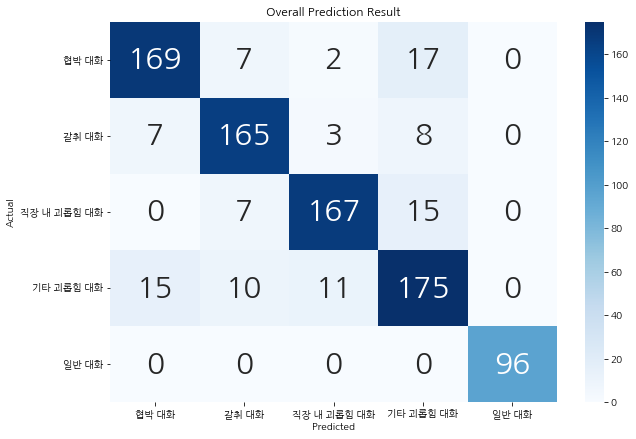

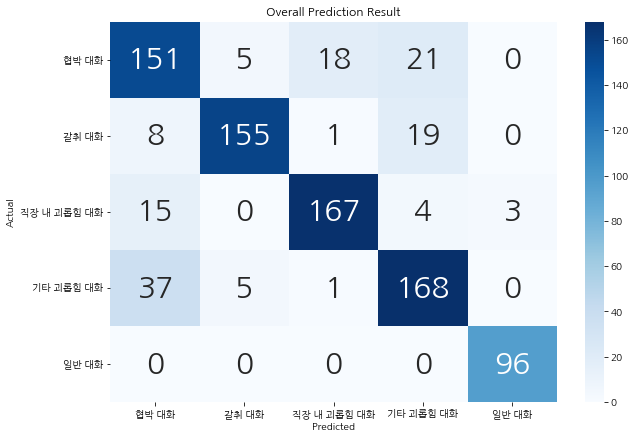

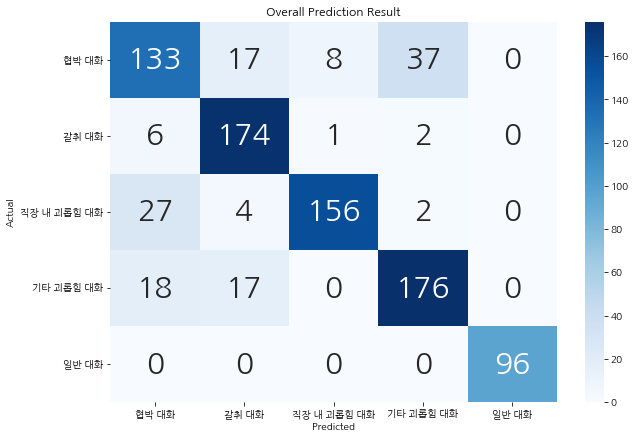

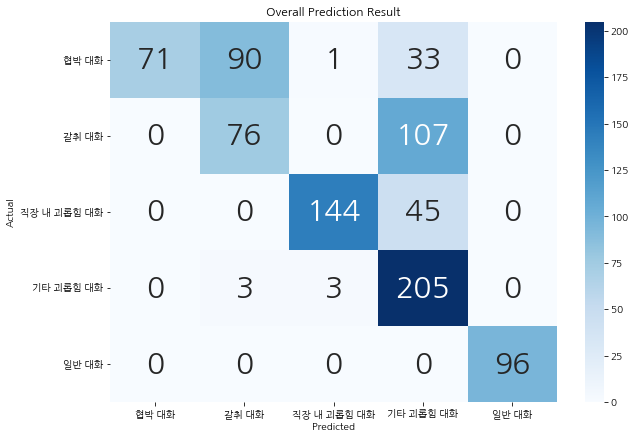

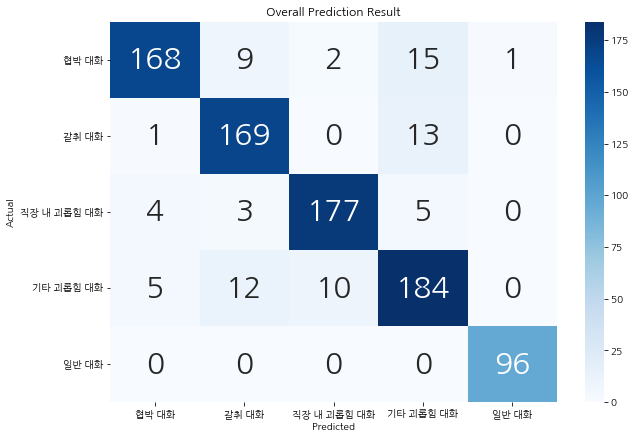

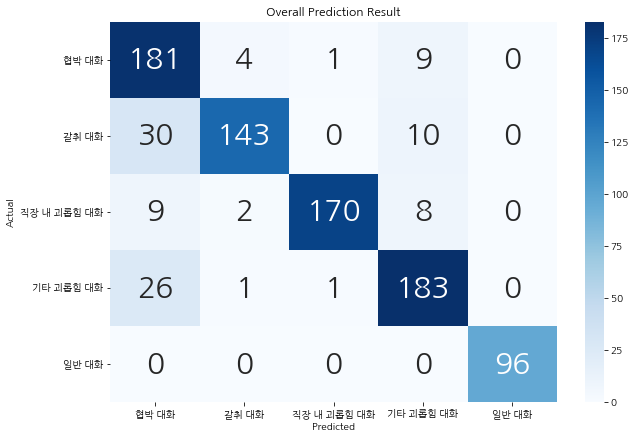

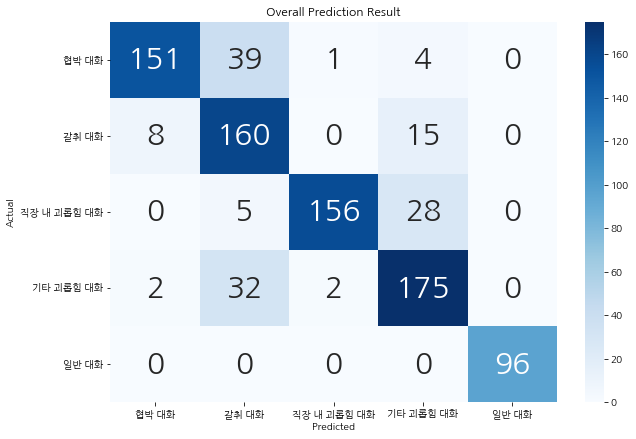

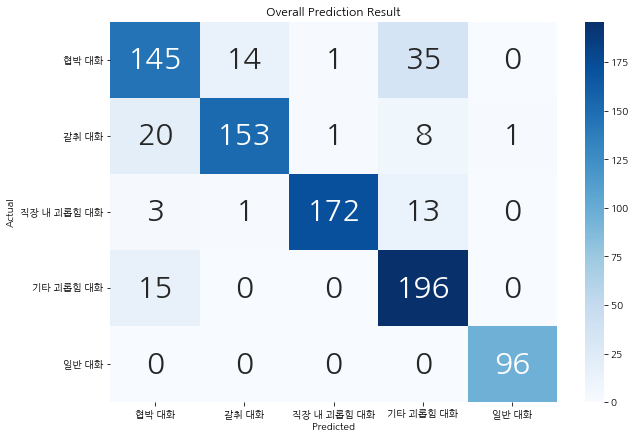

In [76]:
# train()에 인자가 있으므로 wrapper function 정의
def sweep_train():
    train(default_config=default_config, X_train=X_train, X_val=X_val, X_test=X_test, y_test=y_test)

# 팀프로젝트 내에서 sweep 실행
sweep_id = wandb.sweep(sweep_config,
                       entity = 'aiffel_minions',
                       project = 'DLthon_CNN_large_Augmented')


wandb.agent(sweep_id,
            function=sweep_train,
            count=8)